In [2]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import rle_encode, rle_decode, rle_to_string

%matplotlib inline

Pandas pd.read_csv returns a dataFrame object:
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_csv.html

Look here for the fields and methods avaiable in DataFrame class:
https://pandas.pydata.org/pandas-docs/stable/api.html#dataframe

pandas.DataFrame is a csv file basically with column headers and rows and columns. 
pandas.Series is the data structure for a single column of a DataFrame.
i.e. the data in a DataFrame is actually stored in memory as a collection of Series.

Ex. Attribute: df.shape  returns shape
Ex. Method: DataFrame.head([n])	Returns the first n rows.

Indexing notice: 
You can index into the dataframe using [] in different ways: 
    1. df.SomeColumnName[row#]  returns you a single literal. (ex. df.ImageId[50] returns a string)
    2. df.SomeColumnName[row#A : row#B] returns you a series object (a column) containing the rows
       you requested. including row#A excluding row#B. So   df.SomeColumnName[row#A : row#A] returns 
       you an empty series object.
    3. df[row#A : row#B] returns a DataFrame object containing the rows requested an all the columns. 
       df[row#A : row#A] returns an empty DataFrame object.
    4. db[row#A] is a syntax error because [row#] cannot return a literal, and objects are returned 
    only when [] recieves a range due to overloading. 
    
    df.shape   
        (1885, 2)
    
    df.ImageId[50]
        '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac'
    type(df.ImageId[50])
        str
    
    df.ImageId[50:51]
        50    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...
        Name: ImageId, dtype: object
    type(df.ImageId[50:51])
        pandas.core.series.Series
    
    df[50:51]
        ImageId	                                                EncodedPixels
        50	0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...	2252 14 2771 15 3290 15 3808...
    type(df[50:51])
        pandas.core.frame.DataFrame
    df[50]
        !!!Syntax error!!!

    df.ImageId.unique()  
        Uniques are returned in order of appearance. This does NOT sort.
    type(df.ImageId.unique())
        numpy.ndarray
    df.ImageId.unique()[50:51]
        array(['bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d'], dtype=object)
    type(df.ImageId.unique()[50:51])
        numpy.ndarray

In [3]:
df = pd.read_csv('submission_v2.csv')
df.head()

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 7 45358 9 45614 9 45870 9 46126 9 46382 ...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50539 2 50787 11 51043 11 51299 12 51555 11 51...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10886 11 11142 11 11398 12 11654 12 11909 13 1...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,38815 9 39071 10 39326 11 39582 11 39838 11 40...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,51859 8 52115 9 52371 9 52627 9 52883 9 53138 ...


0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


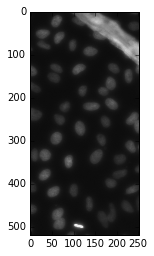

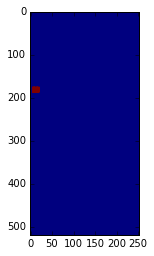

In [77]:
# hs read a single image. Note that you could've used df.ImageId[50] i just wanted to get the same image as below.
hsImageId = df.ImageId[50] #df.ImageId.unique()[50] 
print(hsImageId)
image = cv2.imread('stage1_test/' + hsImageId + '/images/' + hsImageId + '.png')
plt.figure()
plt.imshow(image)


#hs read a single mask
hsRunLengthEncodedMask = df.EncodedPixels[50]
decodedMask = rle_decode(hsRunLengthEncodedMask, image.shape[:2])  #  image.shape == (519, 253, 3)
plt.figure()
plt.imshow(decodedMask)

In [101]:
hsDataset = BowlDataset()
hsDataset.load_bowl('stage1_train')
hsDataset.prepare()
len(hsDataset.image_ids)

In [135]:
#hs this loads the ground truth for 1 training example. Methos is in model.py
# hs_mask contains the masks for all the object in the image. 
# hs_image.shape     == (512, 512, 3)
# hs_masks.shape     == (512, 512, 28)
# hs_bbox.shape      == (28, 4)
# hs_class_ids.shape == (28,)
hs_image, hs_image_meta, hs_class_ids, hs_bbox, hs_masks = modellib.load_image_gt(hsDataset, bowl_config, 50)

In [138]:
hs_class_ids.shape

(28,)

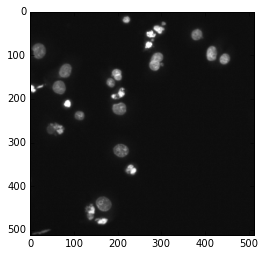

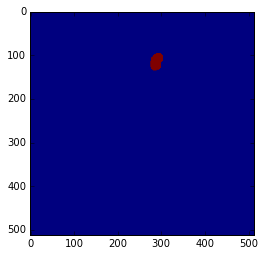

In [136]:
plt.figure()
plt.imshow(hs_image)
plt.figure()
plt.imshow(hs_masks[:,:,0])

In [69]:
def test_image(df, image_id, plot=False):
    image = cv2.imread('stage1_test/' + image_id + '/images/' + image_id + '.png')
    shape = image.shape[:2]
    #hs since rle_decode takes a string, df.EncodedPixels[df.ImageId == image_id] would work in below too.
    for rle in df[df.ImageId == image_id].EncodedPixels:
        try:
            decoded_result = rle_decode(rle, shape)
            plt.figure()
            plt.imshow(image)
            plt.figure()
            plt.imshow(decoded_result)
        except Exception as e:
            print(e)
            print(image_id)
            print('---')

In [ ]:
for image_id in df.ImageId.unique()[50:51]:
    test_image(df, image_id)

# Training Process from train.py and model.py

In [115]:
import os

import sys
import random
import math
import time

from bowl_config import bowl_config
from bowl_dataset import BowlDataset
import utils
import model as modellib
from model import log
from glob import glob

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:


    
model = modellib.MaskRCNN(mode="training", config=bowl_config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
    
# Training dataset
dataset_train = BowlDataset()
dataset_train.load_bowl('stage1_train')
dataset_train.prepare()

# # Validation dataset
dataset_val = BowlDataset()
dataset_val.load_bowl('stage1_train')
dataset_val.prepare()

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#model.train(dataset_train, dataset_val, 
#            learning_rate=bowl_config.LEARNING_RATE, 
#            epochs=1, 
#            layers='heads')

model.train(dataset_train, dataset_val, 
            learning_rate=bowl_config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")